# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 

Group Members: Caitlin Chan, Daniela Perez, David Su

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [ ]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()
nhanes_scaled.shape

(2064, 242)

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

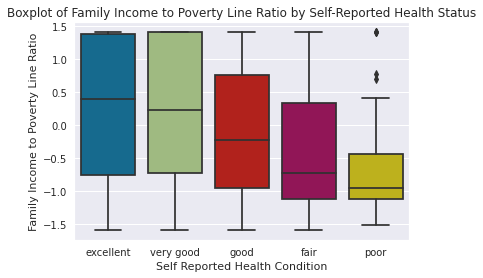

In [ ]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

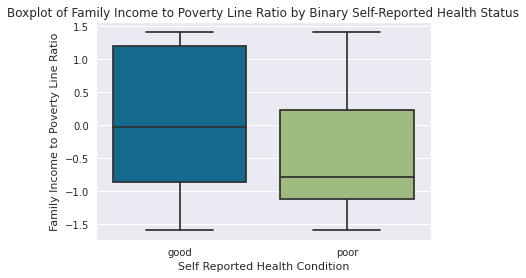

In [ ]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

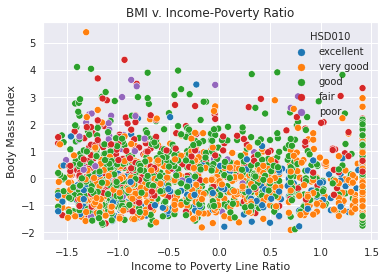

In [ ]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [ ]:
y = nhanes_scaled[['HSD010', 'HSD010_binary']]
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

The variance explained by the first 100 component is: [0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655592 0.01557116 0.01532197 0.01319963 0.01212788
 0.01157936 0.01155979 0.01110002 0.01004577 0.00943214 0.00932319
 0.00880404 0.00869006 0.00840095 0.00826002 0.00796164 0.00782741
 0.00753759 0.00723612 0.00711032 0.00694006 0.0067926  0.00645654
 0.00639577 0.0063167  0.00621726 0.00617651 0.0059252  0.00577335
 0.00568389 0.00562898 0.00561499 0.0055533  0.00549126 0.00542577
 0.00531223 0.00527139 0.00520463 0.00515894 0.00510486 0.00501115
 0.00497821 0.00494958 0.004907   0.00483339 0.00480818 0.00474015
 0.00471088 0.00462531 0.00461806 0.0045811  0.0044957  0.00447783
 0.0044617  0.00437078 0.00435539 0.00430533 0.0042807  0.00424181
 0.00422361 0.00417609 0.00412366 0.0041012  0.00405808 0.00404191
 0.00403215 0.00396492 0.00392857 0.00390194 0.00386071 0.00379186
 0.00377391 0.00375194 0.00366903 0.00364648 0.00362458 0.00360467
 0.003564

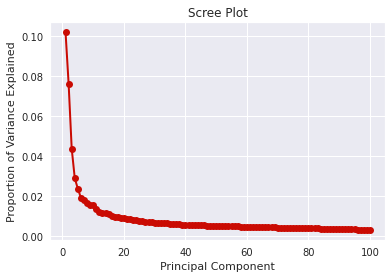

In [ ]:
## Your Answer Here
## It seems the dataset has been scaled, perform PCA
from sklearn.decomposition import PCA

# First, it is a common sense that a desirable number of component should be less than 100, which is the purpose of PCA.
# Therefore, I set the number of component to 100 to see the explanatory power of each component
pca = PCA(n_components=100)
principalComponents_health = pca.fit_transform(nhanes_scaled)
# calculate the explained variance ratio for each component
pca_var = pca.explained_variance_ratio_
print("The variance explained by the first 100 component is:", pca_var)

## Draw a scree plot to visualize the explained variance ratio for each component
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

Based on the Scree plot, we use the elbow method to determine the number of component that we should use for PCA. It seems that the turning point of explained variance occurs at the the fifth component, after which the explanatory power for each additional component is less than 2%. Therefore, we suggest that keeping 5 componenets is the most efficicent way to summarize all the predictor's information. 

In [ ]:
## Redefining a PCA method with 5 components

pca = PCA(n_components= 5)
principalComponents_health = pca.fit_transform(nhanes_scaled)
pca_df = pd.DataFrame(data = principalComponents_health
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
total_var = sum(pca.explained_variance_ratio_)
print("The total variance explained by the first 5 component is:", total_var)



## Making sense of the meaning of these selected components

pca_loading = pca.components_
nhanes_scaled.columns
loading_df = pd.DataFrame(pca_loading, columns = nhanes_scaled.columns, index=[1, 2, 3, 4, 5 ])
loading_df


for i in np.arange(5):
  mid_index = loading_df.iloc[i,].sort_values(ascending = False)[0:5]
  print("Features having the highest loadings on the " +str(i+1) +" PC are:", list(mid_index.index))



The total variance explained by the first 5 component is: 0.27435465024335987
Features having the highest loadings on the 1 PC are: ['DR1TPHOS', 'DR1TKCAL', 'DR1TTFAT', 'DR1TMFAT', 'DR1TS160']
Features having the highest loadings on the 2 PC are: ['OHX09TC', 'OHX08TC', 'OHX07TC', 'OHX10TC', 'OHX11TC']
Features having the highest loadings on the 3 PC are: ['FSDHH', 'FSDAD', 'HOQ065', 'INQ140', 'PAAQUEX']
Features having the highest loadings on the 4 PC are: ['BMXWT', 'BMXARMC', 'BMXWAIST', 'BMXBMI', 'SIAPROXY']
Features having the highest loadings on the 5 PC are: ['DR1TFIBE', 'DR1TFF', 'DMDBORN4', 'DR1TFOLA', 'DR1TVC']


We analyze 5 variables that have the highest loadings on each PC to make sense of these 5 PCs. The variable names are unpacked based on the survey documentation on CDC website. https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx

The first Principal component (PC) mostly captures the information of dietary phosphorus, energy, fat, monounsaturated_fats, Hexadecanoic (gm). It can be named as an dietary energy.

The second PC mostly captures specific tooth count variables, or dental health.

The third PC mostly captures household and adult food security, home ownership, income, weightings, which can be named as socioeconomic status or poverty-related status. 

The forth PC mostly captures weights, arm circumference, waist circumference, BMI, which can be safely named as body shape or BMI. 

The fifth PC mostly captures Food folate, Dietary fiber, Country of birth, Total Folate, Vitamin C, which can be named as dietary nutrition. 

### Barplot of Components

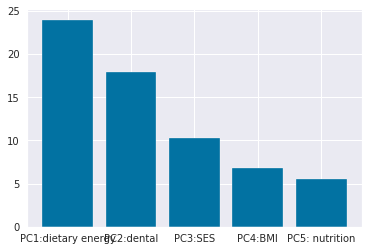

In [ ]:
## Your Answer Here
import numpy as np
import matplotlib.pyplot as plt

# load the variance explained data
varexp = pca.explained_variance_
bars = ('PC1:dietary energy', 'PC2:dental', 'PC3:SES', 'PC4:BMI', 'PC5: nutrition')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, varexp)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()


Although the scree plot above has visualized the precentage of variance explained by each PC, the bar plot here visualizes the variance explained by the first 5 PCs. 

### How many components will you use to fit a supervised learning model?

Based on the above results (scree plots and the bar plot), we believe choose 5 components is appropriate due to its efficiency and interpretability. These 5 components together explains 27.4% of the total variance of the target , which efficiently summary all information presentated by 241 features in our dataset and are unlikely to be random noise (with each having more than 2% explanatory power). In addition, they are easily interpretable and we can make sense of why high values in a set of features contribute to a high score in each PC. 

### 2D Scatterplot of the first two components

In [ ]:
y = y.reset_index() 

In [ ]:
pca_df_withtarget = pca_df
pca_df_withtarget['HSD010_binary'] =  y['HSD010_binary']
pca_df_withtarget['color'] = np.where(pca_df_withtarget['HSD010_binary'] == 'good', 'g', 'r')
pca_df_green = pca_df_withtarget[pca_df_withtarget['color'] == "g"]
pca_df_red = pca_df_withtarget[pca_df_withtarget['color'] == "r"]

<Figure size 432x288 with 0 Axes>

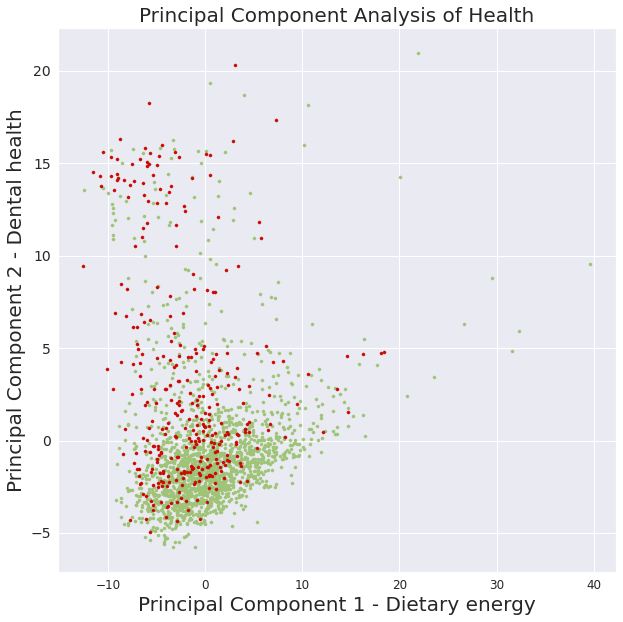

In [ ]:
## Your Answer Here
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1 - Dietary energy',fontsize=20)
plt.ylabel('Principal Component 2 - Dental health',fontsize=20)
plt.title("Principal Component Analysis of Health",fontsize=20)

plt.scatter(pca_df_green['PC 1'], pca_df_green['PC 2'], c='g', s = 10)

plt.scatter(pca_df_red['PC 1'], pca_df_red['PC 2'], c='r', s = 10)

plt.legend(prop={'size': 15})
plt.show()

Although the plot seems overlapping, individuals with poor health (red) is much fewer than those with good health (green). In this case, we see from the scatter plot that individuals with good health are generally more likely to be located on the lower right than the poor-health individuals, meaning that having a slightly higher score on PC 1 and lower score on PC 2 is associated with better self-reported health. But such association is not causation and may be confounded by factors such as age. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [ ]:
## Your Answer Here
from sklearn.cluster import KMeans
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


We chose the K-means clustering algorithm. K-means randomly assigns cases to a pre-specified k number of clusters. The centroid (mean of X's) of each cluster is calculated, and each case is assigned to the nearest cluster. The centroid is updated once the cases are assigned, and the points are re-assigned to the new centroids. This continues iteratively until the centroids stabilize and reassignment stops. K-means minimizes the within-cluster sum of squares (WCSS), a measure of the variance within the clusters.

### Cluster nhanes

We decided on 4 clusters based on the results of the elbow method.

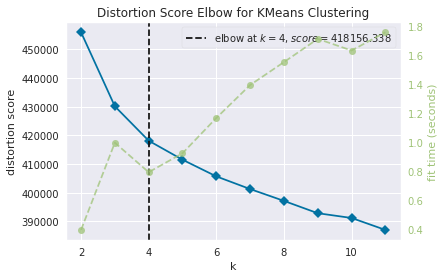

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

#Elbow method to choose number of clusters

# Instantiate the clustering model and visualizer
np.random.seed(10)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(nhanes_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
## Your Answer Here

#Run k-means cluster analysis with 4 clusters

np.random.seed(10)

kmeans = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(nhanes_scaled)

In [ ]:
#print results of cluster analysis

print("Centers")
print(kmeans.cluster_centers_)
print()

print("Labels")
print(kmeans.labels_)
print()

for point, label in zip(nhanes_scaled, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.00000000e+00  3.67141188e-02  0.00000000e+00  5.82322602e-02
  -3.10766755e-02  4.19531034e-02 -8.48081216e-02 -5.73055774e-02
   5.76924951e-02 -5.34137463e-02 -1.75281028e-02  1.54795055e-02
  -4.17180471e-02  1.86788200e-01 -2.61189999e-01 -1.68998408e-01
  -2.55200713e-01 -2.23453462e-01 -6.04448570e-02 -2.57041699e-01
  -2.62496137e-01 -2.31335509e-01 -1.97850718e-01 -1.44922869e-01
  -9.60915229e-02 -1.65560522e-01 -8.66607712e-02  1.71394073e-02
   2.08210518e-02 -1.69843645e-01 -1.56671162e-01 -1.71749032e-01
  -1.05113117e-01 -1.43990693e-01 -1.50114885e-01 -5.60418314e-02
  -1.51839974e-01 -1.26985928e-01 -1.52108453e-01  1.68810252e-02
  -7.71463882e-02  1.97817568e-02 -1.92690123e-01 -2.05237258e-01
  -9.85211321e-02 -1.78139030e-01 -1.65671430e-01 -7.23173865e-02
  -1.92185385e-01 -1.06545956e-01 -1.77131776e-01  1.01428533e-02
  -1.49402671e-01 -1.56535440e-01 -1.53171451e-01 -1.62333465e-01
  -9.17946778e-02 -1.95446488e-01 -2.69114335e-01 -2.64497973e-01
  

In [ ]:
#link clusters from 1st analysis to principal components

pca_df['label'] = 0

for point, label in zip(nhanes_scaled, kmeans.labels_):
    pca_df['label'] = kmeans.labels_

pca_df

,PC 1,PC 2,PC 3,PC 4,PC 5,HSD010_binary,color,label
0,9.527811,-0.816225,-1.867039,-2.111864,-3.932296,good,g,2
1,-5.838339,-3.692572,3.805749,-1.029167,0.396247,good,g,1
2,-0.719454,-2.573200,0.907939,-4.757292,-1.801362,good,g,0
3,3.533627,-2.576982,-3.249103,-0.405060,3.997647,good,g,0
4,-6.872094,-4.194241,0.886850,-0.850920,-0.528859,good,g,1
...,...,...,...,...,...,...,...,...
2059,2.643319,-1.689356,-0.702583,-0.539221,-1.021820,good,g,0
2060,1.037906,-0.118065,5.556519,1.626697,0.960900,good,g,1
2061,1.130253,-0.970432,3.415359,1.207324,-3.627910,poor,r,1
2062,7.145093,-0.376753,1.753529,-0.939857,-4.669709,good,g,2


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

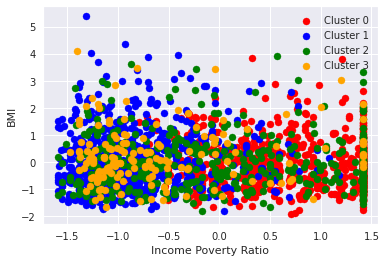

In [ ]:
## Your Answer Here

fig = plt.figure()
ax1 = fig.add_subplot(111)

nhanes_scaled_np = nhanes_scaled[['INDFMPIR','BMXBMI']].to_numpy()

ax1.scatter(*nhanes_scaled_np[kmeans.labels_==0,:].T, s=50, c='red', label='Cluster 0')
ax1.scatter(*nhanes_scaled_np[kmeans.labels_==1,:].T, s=50, c='blue', label='Cluster 1')
ax1.scatter(*nhanes_scaled_np[kmeans.labels_==2,:].T, s=50, c='green', label='Cluster 2')
ax1.scatter(*nhanes_scaled_np[kmeans.labels_==3,:].T, s=50, c='orange', label='Cluster 3')

#ax1.scatter(kmeans.cluster_centers_.T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper right')
plt.xlabel('Income Poverty Ratio')
plt.ylabel('BMI')
plt.show()

## Your Answer Here

From the scatterplot, it looks as though cluster 0 and cluster 3 are correlated with a positive income poverty ratio, while cluster 1 is correlated with a negative income poverty ratio. There is not a clear correlation of cluster 2 with either BMI or income poverty ratio.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here

np.random.seed(10)

pca_np = pca_df.drop(columns=['HSD010_binary', 'color']).to_numpy()

kmeans_pca = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(pca_np)

In [ ]:
#link clusters from 2nd analysis to principal components

pca_df['label 2'] = 0

for point, label in zip(pca_np, kmeans_pca.labels_):
    pca_df['label 2'] = kmeans_pca.labels_

pca_df

,PC 1,PC 2,PC 3,PC 4,PC 5,HSD010_binary,color,label,label 2
0,9.527811,-0.816225,-1.867039,-2.111864,-3.932296,good,g,2,2
1,-5.838339,-3.692572,3.805749,-1.029167,0.396247,good,g,1,0
2,-0.719454,-2.573200,0.907939,-4.757292,-1.801362,good,g,0,1
3,3.533627,-2.576982,-3.249103,-0.405060,3.997647,good,g,0,1
4,-6.872094,-4.194241,0.886850,-0.850920,-0.528859,good,g,1,0
...,...,...,...,...,...,...,...,...,...
2059,2.643319,-1.689356,-0.702583,-0.539221,-1.021820,good,g,0,1
2060,1.037906,-0.118065,5.556519,1.626697,0.960900,good,g,1,0
2061,1.130253,-0.970432,3.415359,1.207324,-3.627910,poor,r,1,0
2062,7.145093,-0.376753,1.753529,-0.939857,-4.669709,good,g,2,2


In [ ]:
pca_df['cluster color'] = 0

pca_df['cluster color'] = np.where(pca_df['label 2'] == 0, 'red', pca_df['cluster color'])
pca_df['cluster color'] = np.where(pca_df['label 2'] == 1, 'blue', pca_df['cluster color'])
pca_df['cluster color'] = np.where(pca_df['label 2'] == 2, 'green', pca_df['cluster color'])
pca_df['cluster color'] = np.where(pca_df['label 2'] == 3, 'orange', pca_df['cluster color'])

pca_df_red = pca_df[pca_df['cluster color'] == "red"]
pca_df_blue = pca_df[pca_df['cluster color'] == "blue"]
pca_df_green = pca_df[pca_df['cluster color'] == "green"]
pca_df_orange = pca_df[pca_df['cluster color'] == "orange"]

          PC 1      PC 2      PC 3      PC 4      PC 5 HSD010_binary color  \
1    -5.838339 -3.692572  3.805749 -1.029167  0.396247          good     g   
4    -6.872094 -4.194241  0.886850 -0.850920 -0.528859          good     g   
6    -5.721710 -3.652450  0.148261  1.477650 -1.924601          good     g   
11   -1.131714 -0.742484  0.322127  2.971251  6.181416          good     g   
13   -6.063698  0.004656  4.635369  3.233784 -1.413114          poor     r   
...        ...       ...       ...       ...       ...           ...   ...   
2053  0.347398 -1.781987  2.710044 -1.694794  3.182297          good     g   
2056  1.007221 -2.283377  3.427299 -1.082932 -0.453941          poor     r   
2058 -4.319911 -3.485026  0.361147 -0.570668 -0.767666          good     g   
2060  1.037906 -0.118065  5.556519  1.626697  0.960900          good     g   
2061  1.130253 -0.970432  3.415359  1.207324 -3.627910          poor     r   

      label  label 2 cluster color  
1         1        0      

<Figure size 432x288 with 0 Axes>

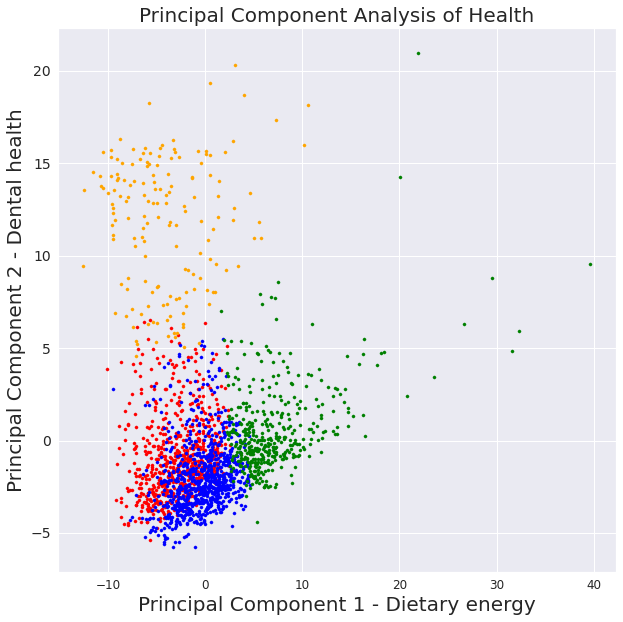

In [ ]:
## Your Answer Here
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1 - Dietary energy',fontsize=20)
plt.ylabel('Principal Component 2 - Dental health',fontsize=20)
plt.title("Principal Component Analysis of Health",fontsize=20)


plt.scatter(pca_df_red['PC 1'], pca_df_red['PC 2'], c='red', s = 10)
plt.scatter(pca_df_blue['PC 1'], pca_df_blue['PC 2'], c='blue', s = 10)
plt.scatter(pca_df_green['PC 1'], pca_df_green['PC 2'], c='green', s = 10)
plt.scatter(pca_df_orange['PC 1'], pca_df_orange['PC 2'], c='orange', s = 10)

plt.legend(prop={'size': 15})
plt.show()


## Your Answer Here

The clusters are fairly distinct and separated when mapped against the first two principal components. Cluster 3 (orange), is clearly positively associated with dental health and negatively associated with dietary energy. Cluster 2 (green), is positively associated with dietary energy and centered a bit below the null for dental health, with a positive skew. Cluster 1 (blue) and 0 (red) overlap the most. Cluster 1 is centered around the null for dietary energy, and negatively associated with dental health. Cluster 0 is negatively associated with dietary energy, and centered below the null for dental health, with a positive skew.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
#Reload dataset
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()
nhanes_scaled.shape

y = nhanes_scaled['HSD010']# either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010'], axis = 1) # drop out any columns that aren't features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import keras
from keras.utils import np_utils 


# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(
    Dense(6, input_dim= 241, activation= 'relu')
)

model.add(
    Dense(6, activation= 'relu')
)


model.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model.evaluate(X_test, y_test, verbose=0)
print("Model Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 2s - loss: 2.9202 - accuracy: 0.3572 - val_loss: 2.7375 - val_accuracy: 0.3934 - 2s/epoch - 218ms/step
Epoch 2/10
8/8 - 0s - loss: 2.5440 - accuracy: 0.3786 - val_loss: 2.4712 - val_accuracy: 0.2907 - 70ms/epoch - 9ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2960 - accuracy: 0.2661 - val_loss: 2.2138 - val_accuracy: 0.2442 - 77ms/epoch - 10ms/step
Epoch 4/10
8/8 - 0s - loss: 2.1418 - accuracy: 0.2209 - val_loss: 1.9876 - val_accuracy: 0.1899 - 172ms/epoch - 21ms/step
Epoch 5/10
8/8 - 0s - loss: 1.9788 - accuracy: 0.1596 - val_loss: 1.9619 - val_accuracy: 0.1395 - 89ms/epoch - 11ms/step
Epoch 6/10
8/8 - 0s - loss: 2.0273 - accuracy: 0.1202 - val_loss: 1.9997 - val_accuracy: 0.1298 - 73ms/epoch - 9ms/step
Epoch 7/10
8/8 - 0s - loss: 2.0302 - accuracy: 0.1202 - val_loss: 1.9816 - val_accuracy: 0.1318 - 80ms/epoch - 10ms/step
Epoch 8/10
8/8 - 0s - loss: 2.0138 - accuracy: 0.1227 - val_loss: 1.9730 - val_accuracy: 0.1279 - 70ms/epoch - 9ms/step
Epoch 9/10
8/8 - 0s - loss: 1.9894 

### Neural Network on Principal Components

In [ ]:
pca_df['HSD010_binary'] =pca_df['HSD010_binary'].replace({'good':1,'poor':0})
#Define training and testing datasets
y = pca_df['HSD010_binary'] 
X = pca_df.drop(columns=['HSD010_binary', 'color','label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#Run the model
model_pca = Sequential()

model_pca.add(
    Dense(2, input_dim= 5, activation= 'relu')
)

model_pca.add(
    Dense(2, activation= 'relu')
)


model_pca.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model_pca.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model_pca.evaluate(X_test, y_test, verbose=0)
print("Model PCA Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 1s - loss: 3.7129 - accuracy: 0.6202 - val_loss: 1.6762 - val_accuracy: 0.8488 - 623ms/epoch - 78ms/step
Epoch 2/10
8/8 - 0s - loss: 1.9555 - accuracy: 0.8359 - val_loss: 1.8569 - val_accuracy: 0.8488 - 37ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 1.9114 - accuracy: 0.8359 - val_loss: 1.6720 - val_accuracy: 0.8488 - 52ms/epoch - 6ms/step
Epoch 4/10
8/8 - 0s - loss: 1.8016 - accuracy: 0.8359 - val_loss: 1.6888 - val_accuracy: 0.8488 - 50ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.8076 - accuracy: 0.8359 - val_loss: 1.6869 - val_accuracy: 0.8488 - 52ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 1.7926 - accuracy: 0.8359 - val_loss: 1.6829 - val_accuracy: 0.8488 - 37ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 1.7609 - accuracy: 0.8359 - val_loss: 1.5901 - val_accuracy: 0.8488 - 59ms/epoch - 7ms/step
Epoch 8/10
8/8 - 0s - loss: 1.7473 - accuracy: 0.8359 - val_loss: 1.6014 - val_accuracy: 0.8488 - 33ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 1.7543 - a

### Neural Network on Principal Components + Cluster Membership

In [ ]:
#Define training and testing datasets
y = pca_df['HSD010_binary'] 
X = pca_df.drop(columns=['HSD010_binary', 'color'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#Run the model
model_pcac = Sequential()

model_pcac.add(
    Dense(2, input_dim= 6, activation= 'relu')
)

model_pcac.add(
    Dense(2, activation= 'relu')
)


model_pcac.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model_pcac.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model_pcac.evaluate(X_test, y_test, verbose=0)
print("Model PCA-Cluster Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 1s - loss: 3.4024 - accuracy: 0.7778 - val_loss: 2.1195 - val_accuracy: 0.8488 - 655ms/epoch - 82ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2353 - accuracy: 0.8359 - val_loss: 2.1218 - val_accuracy: 0.8488 - 55ms/epoch - 7ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2980 - accuracy: 0.8359 - val_loss: 2.1551 - val_accuracy: 0.8488 - 36ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2439 - accuracy: 0.8359 - val_loss: 1.9708 - val_accuracy: 0.8488 - 46ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 2.1351 - accuracy: 0.8359 - val_loss: 1.9257 - val_accuracy: 0.8488 - 36ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 2.0368 - accuracy: 0.8359 - val_loss: 1.7794 - val_accuracy: 0.8488 - 41ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 2.0314 - accuracy: 0.8359 - val_loss: 1.9012 - val_accuracy: 0.8488 - 36ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 2.0702 - accuracy: 0.8359 - val_loss: 1.9134 - val_accuracy: 0.8488 - 36ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 2.0513 - a

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is a dimension reduction technique that condenses the information of all features, provide principal componenet scores for each individual, and it makes interpretable choices for abridging and simplifying information. But PCA does not directly show the similarity among different individuals. 

However, clustering makes use of the information of different features and display the similarity among different individuals but does not provide a concrete and interpretable reason for the clustering decisions (as in PCA). 

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

PCA reduces the number of features and dimensionality which improved the efficiency of the algorithm for cluster analysis, improving performance and reducing noise.

In the Neural network analysis, using PCA vs the original features improved the performance by a lot, but there wasn't much difference when adding the cluster labels to that model.

We likely didn't see gains from this combination because the principal components and clusters were fairly correlated and of similar dimensions (5 vs 4).

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised methods allow us to simplify features that can then be input into a supervised model. With "big data", using the raw features may not be computationally feasible given the volume and complexity of the data. The unsupervised methods can help pinpoint key constructs in the data and reduce multi-dimensionality.